In [ ]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [ ]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [ ]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [ ]:
!rm  -r fire-dataset/validation/

In [ ]:
!ls fire-dataset/train

annotations  images


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 13 03:31:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-05-13 03:31:58--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     361  --.-KB/s    in 0s      

2021-05-13 03:31:58 (23.5 MB/s) - ‘install_colab.sh’ saved [361/361]

  Cloning git://github.com/airctic/icevision.git to /tmp/pip-install-ro67d2_g/icevision
  Running command git clone -q git://github.com/airctic/icevision.git /tmp/pip-install-ro67d2_g/icevision
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
  

In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:16


0B [00:00, ?B/s]

In [ ]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [ ]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [ ]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/small (72).jpg'),
 Path('fire-dataset/train/images/pic (70).jpg'),
 Path('fire-dataset/train/images/pic (204).jpg')]

In [ ]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/img (60).xml'),
 Path('fire-dataset/train/annotations/pic (214).xml'),
 Path('fire-dataset/train/annotations/small (96).xml')]

In [ ]:
class_map = ClassMap(['fire'])

In [ ]:
parser = parsers.VOCBBoxParser(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)
parser.class_map

<ClassMap: {'background': 0, 'fire': 1}>

In [ ]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

  0%|          | 0/502 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

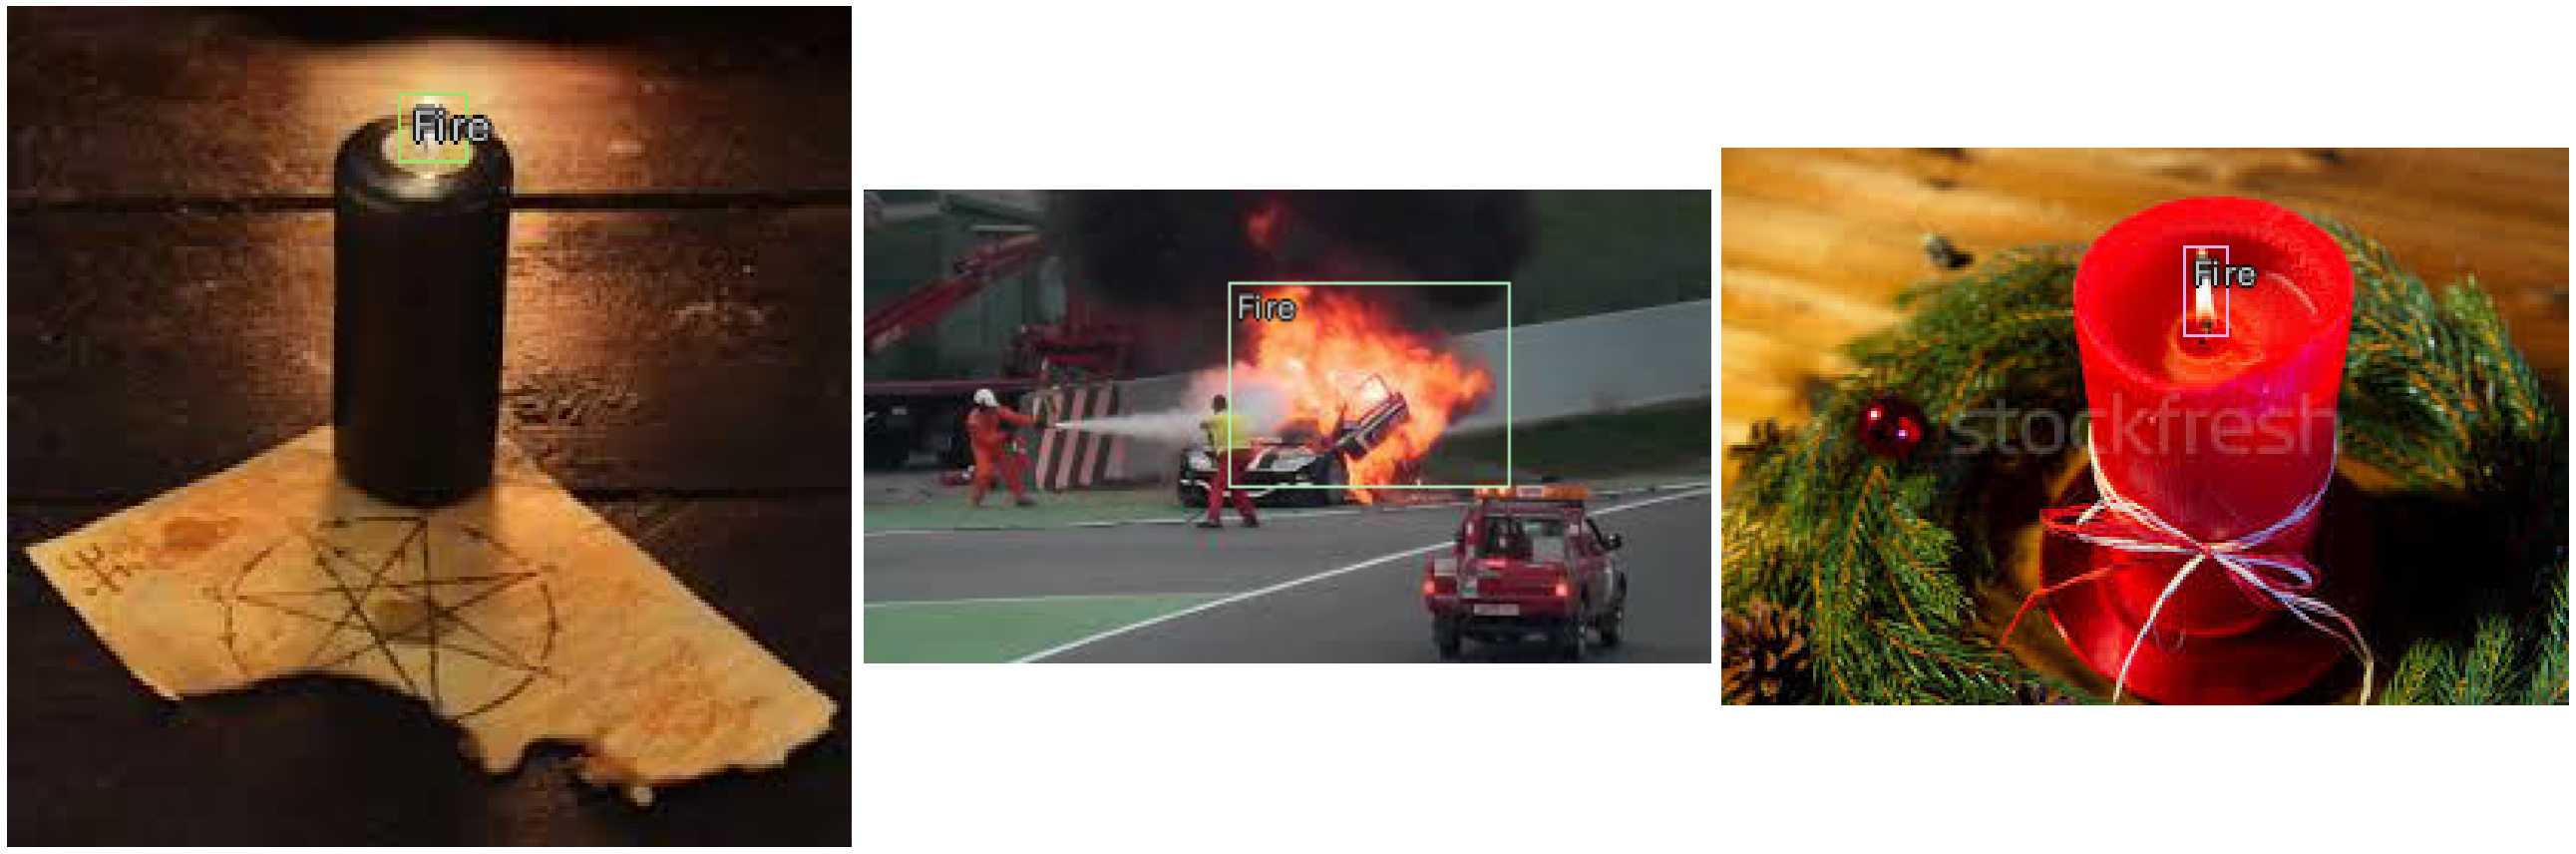

In [ ]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [ ]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

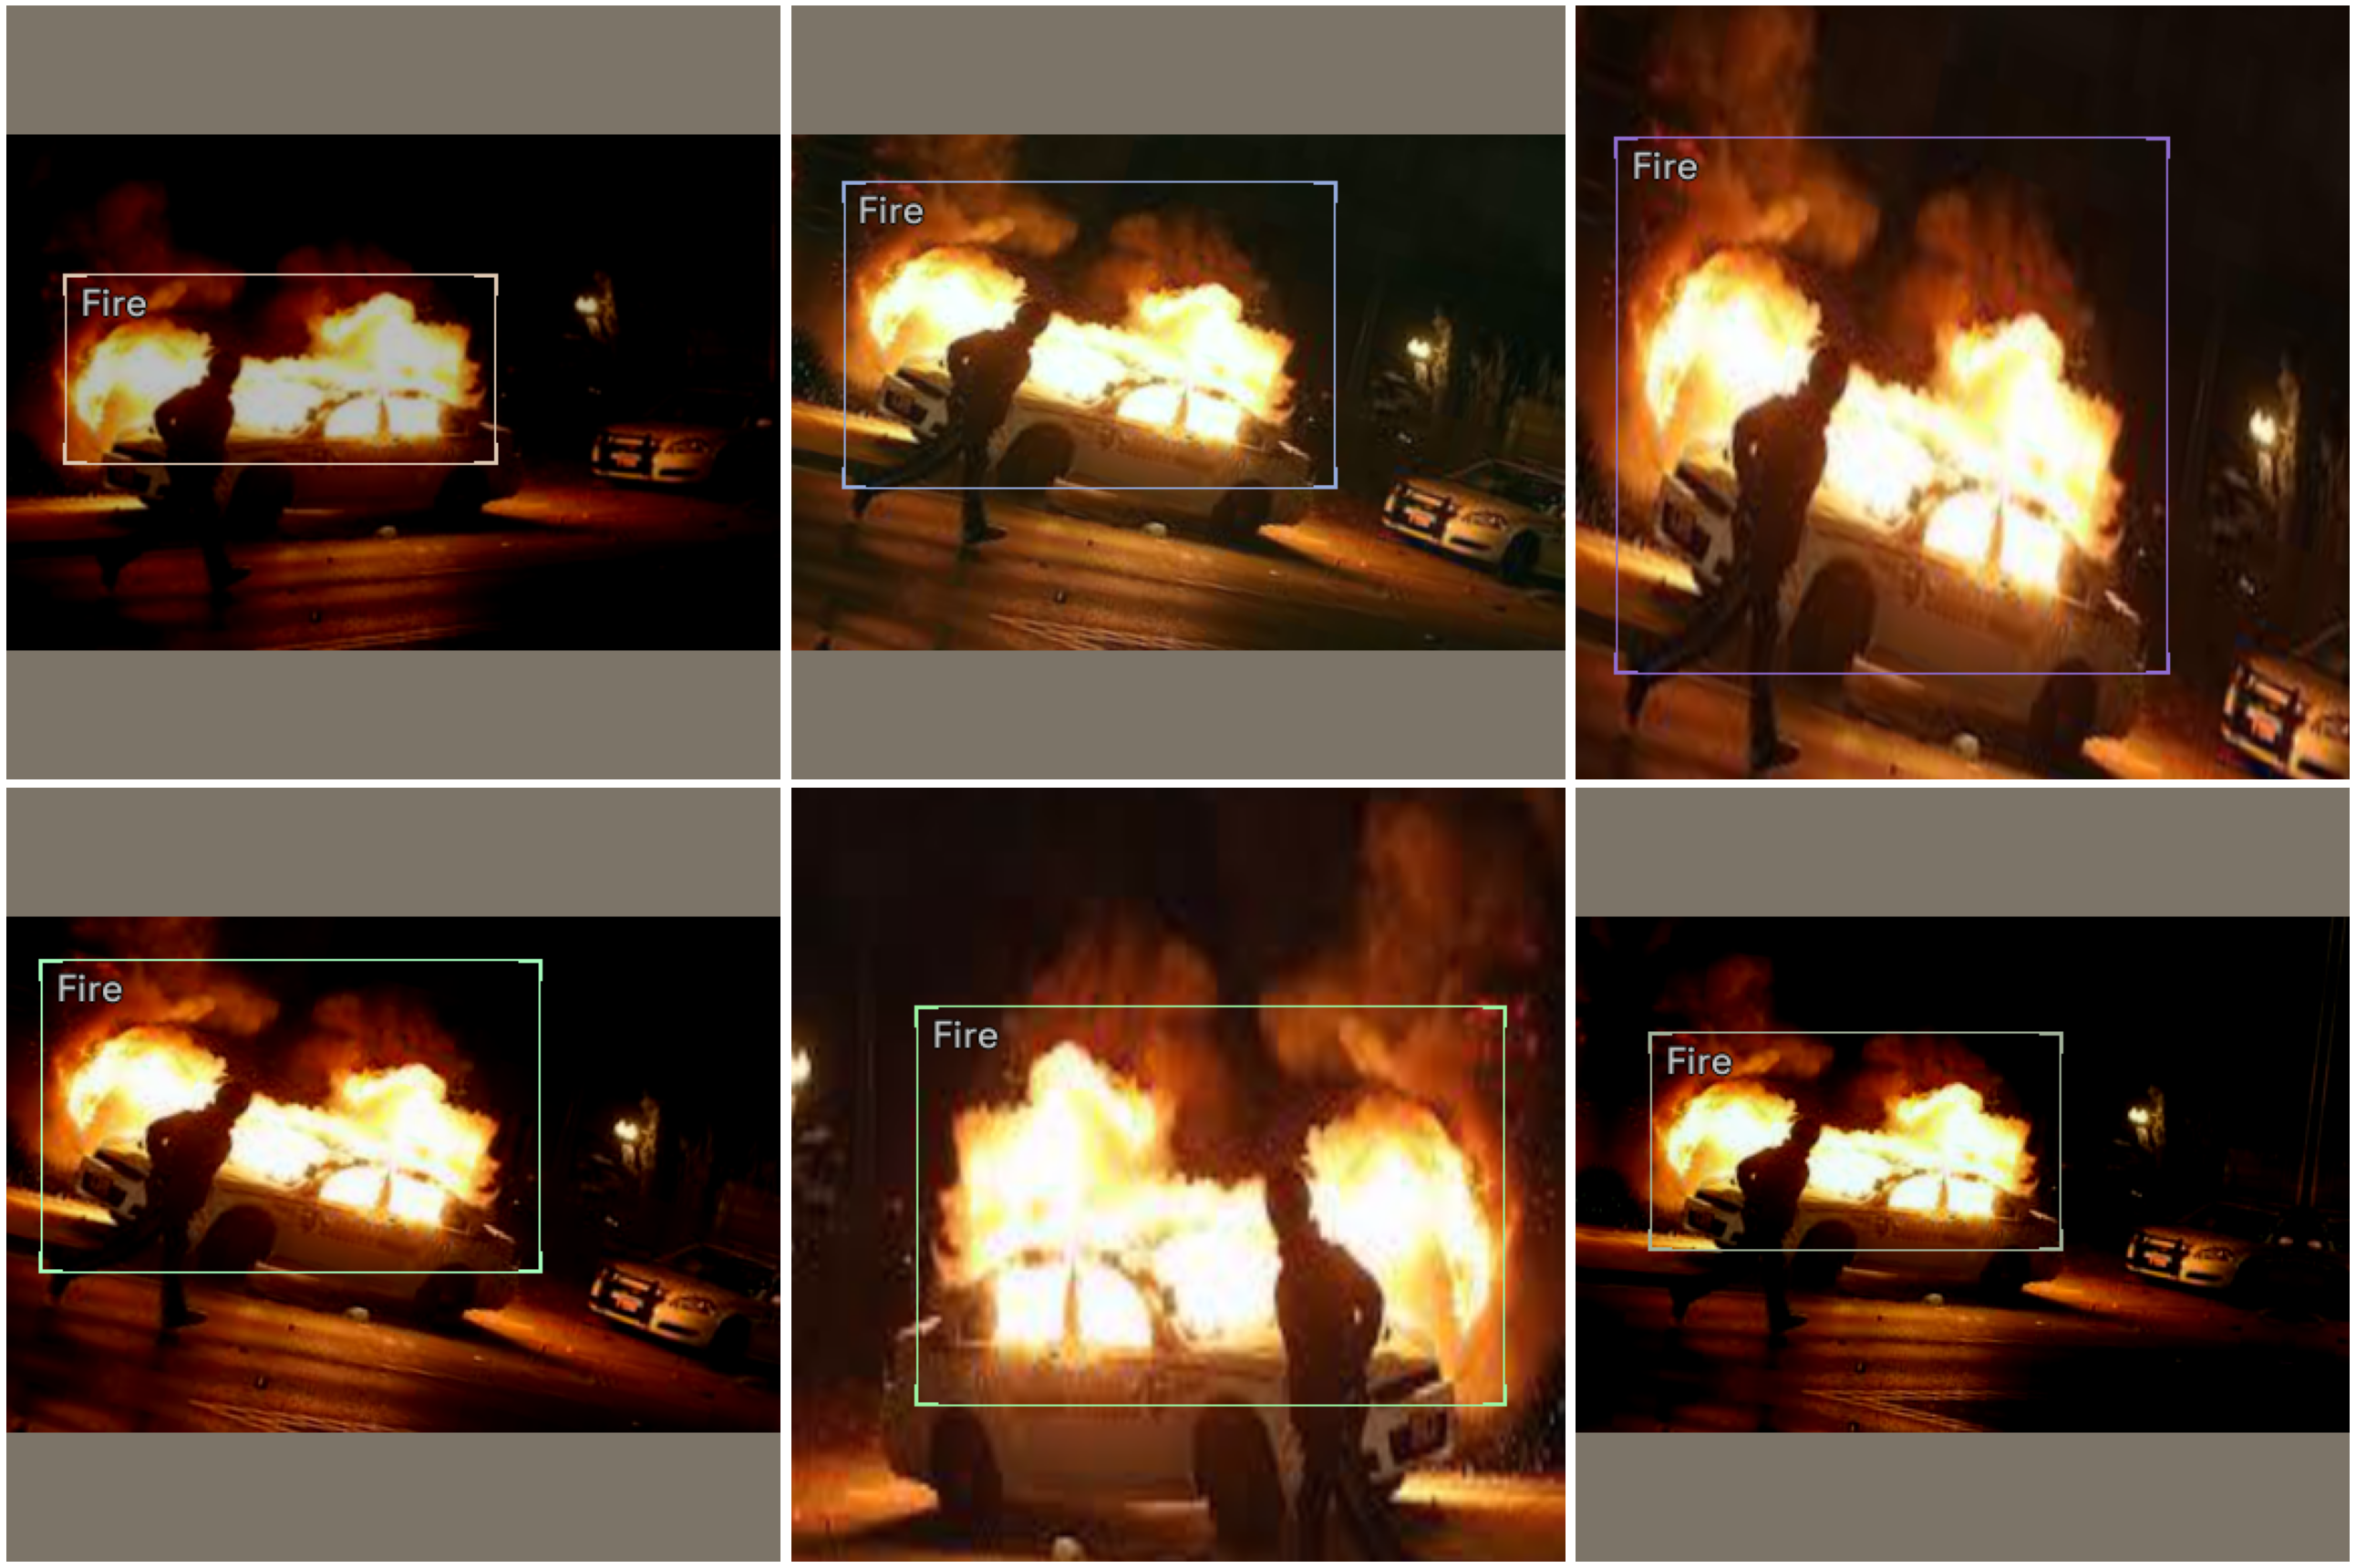

In [ ]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

In [ ]:
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small

extra_args = {}
extra_args['img_size'] = size

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


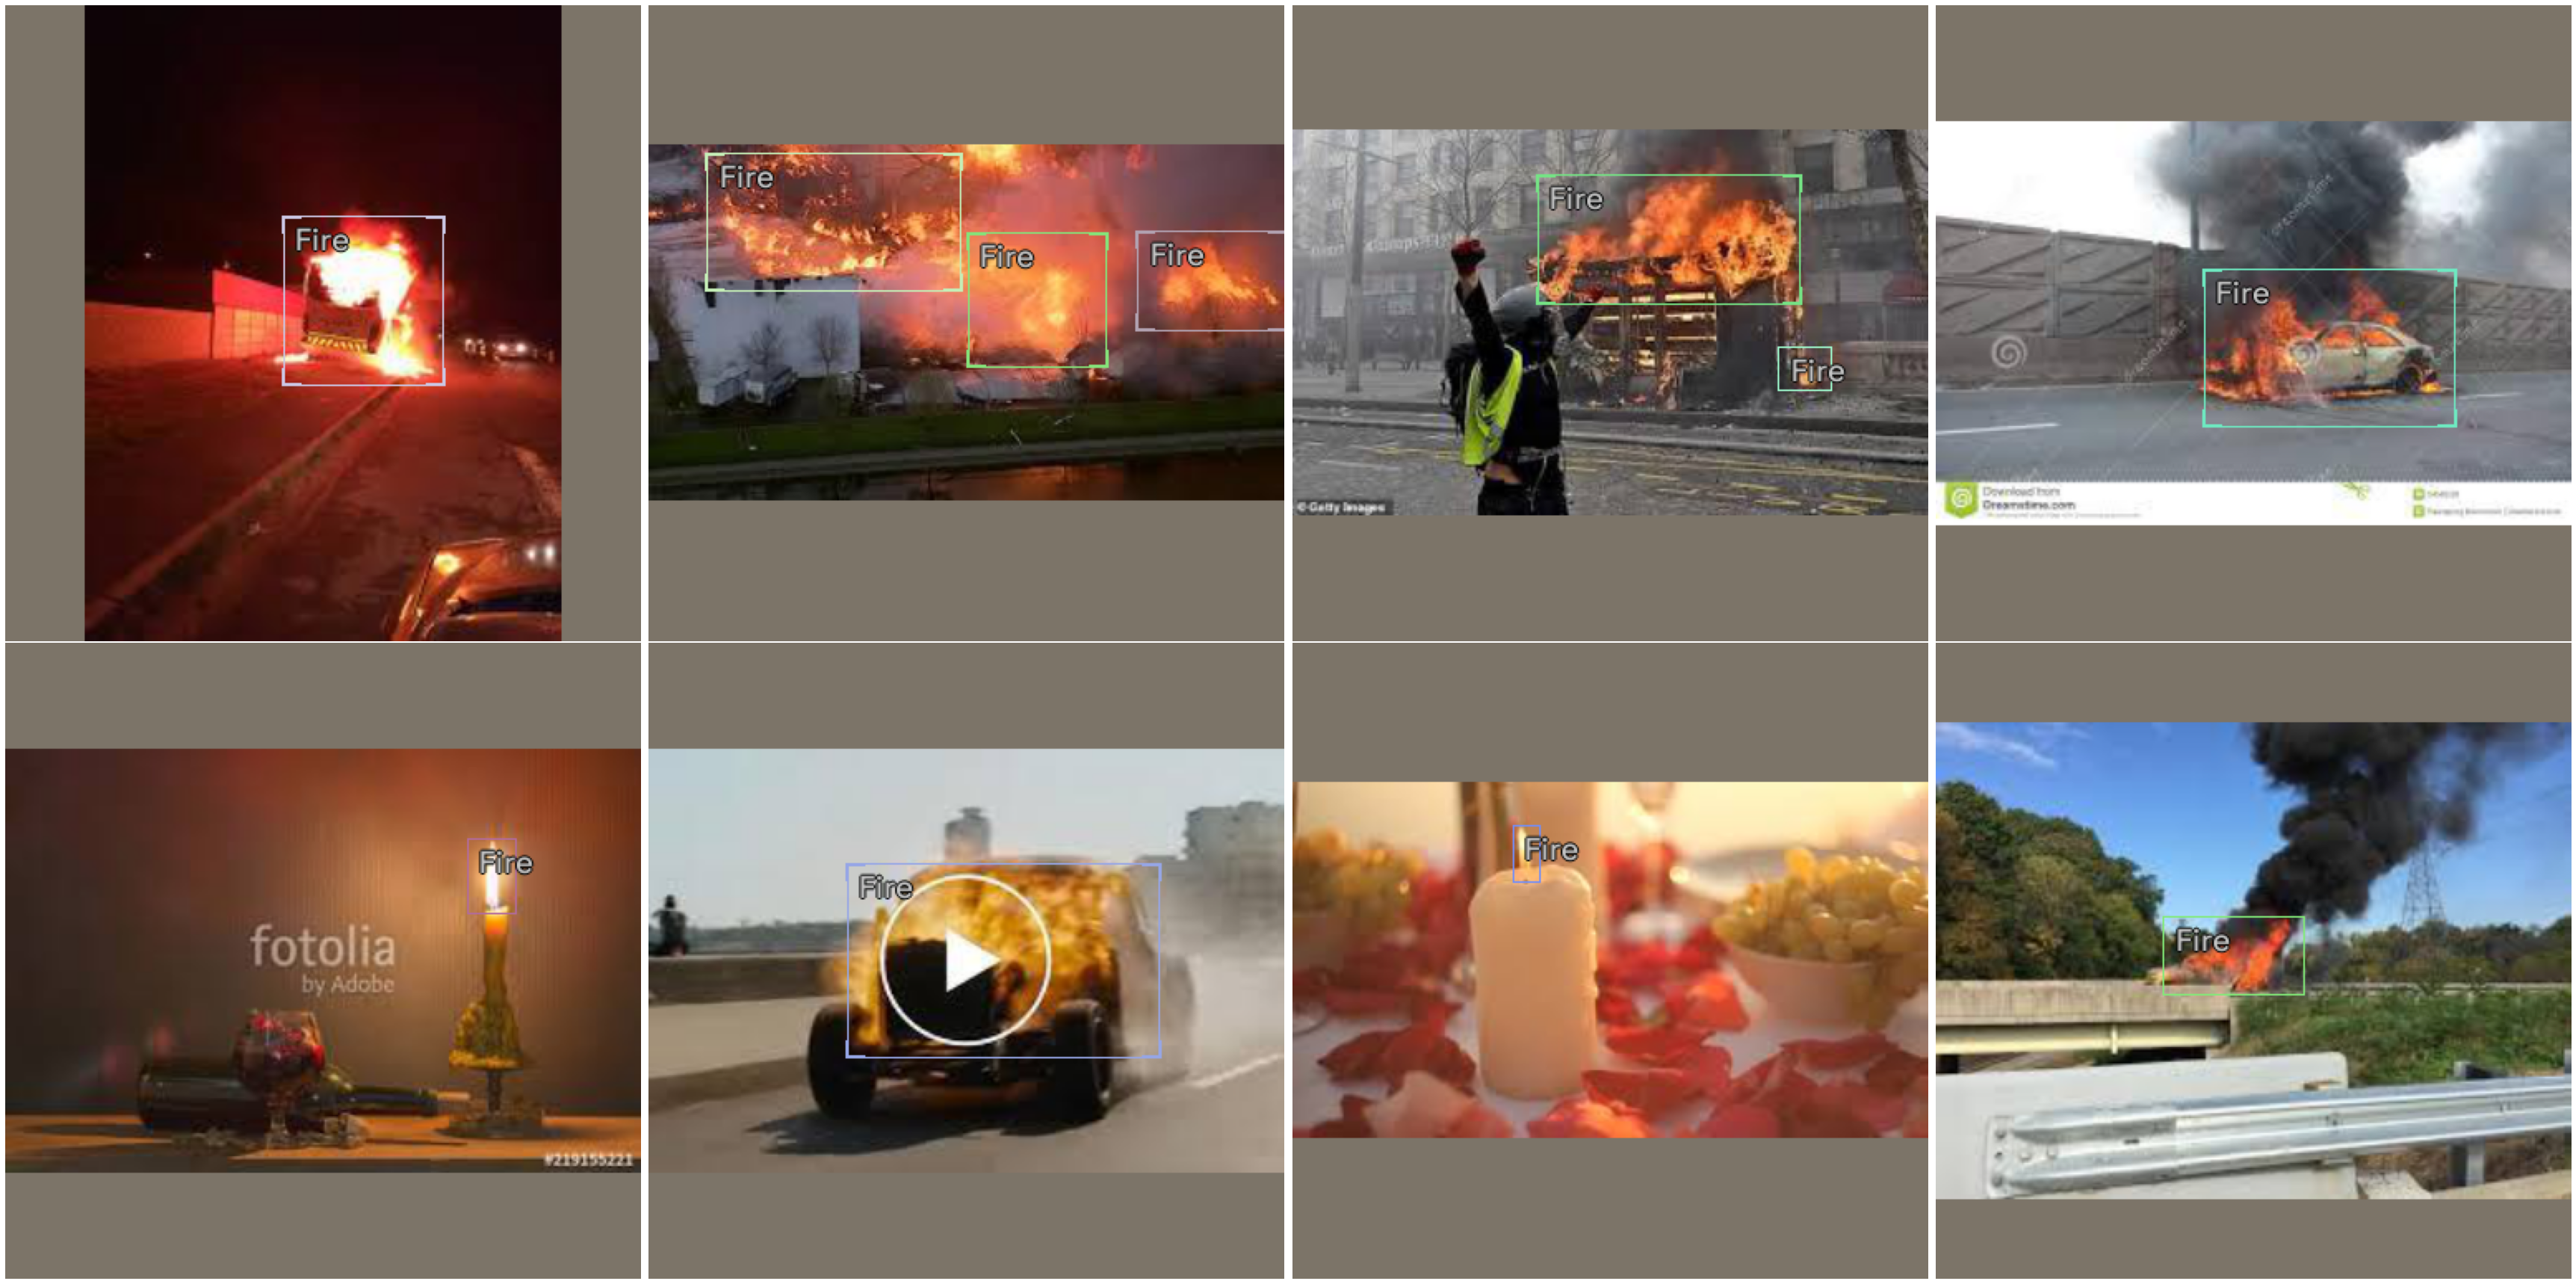

In [ ]:
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

Creating a fastai compatible Learner using the fastai interface.

When I joined the source training and validation data to get a larger number of images, the learning rate changed considerably

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0008317637839354575)

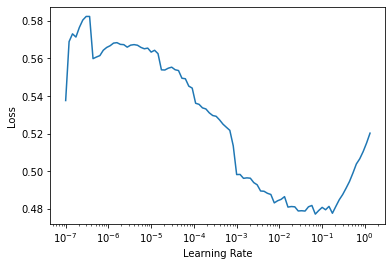

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 1e-4, freeze_epochs=1)

Now do more epochs

In [ ]:
learn.fine_tune(100, 3e-3, freeze_epochs=1)

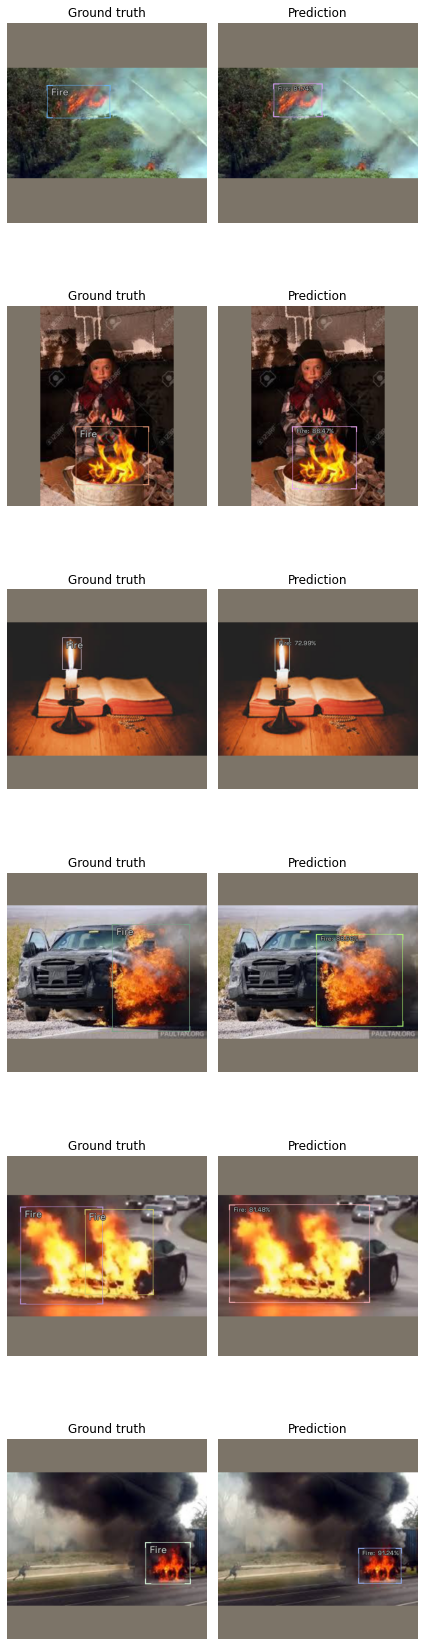

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)